<a href="https://colab.research.google.com/github/7amzaGH/Network-Intrusion-Detection-Using-Machine-Learning/blob/main/notebooks/Network_Intrusion_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. LIBRARY IMPORTS**



In [2]:
# ============================================================================
# 1. LIBRARY IMPORTS
# ============================================================================
!pip install optuna
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Machine Learning - Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB

# Machine Learning - Model Selection
from sklearn.model_selection import train_test_split, cross_val_score

# Machine Learning - Evaluation
from sklearn.metrics import (confusion_matrix, classification_report,
                             f1_score, precision_score, recall_score,
                             accuracy_score, roc_curve, auc)

# Feature Selection
from sklearn.feature_selection import RFE

# Hyperparameter Optimization
import optuna

# Additional Libraries
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
import itertools
import time
import warnings

# Configuration
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(" All libraries imported successfully!")
print("=" * 80)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.2 MB/s eta 0:00:00
 All libraries imported successfully!


# **2. DATA LOADING**

In [3]:
# ============================================================================
# 2. DATA LOADING
# ============================================================================

print("\n📂 LOADING DATA")
print("=" * 80)

# Load training and test datasets
train = pd.read_csv('Train_data.csv')
test = pd.read_csv('Test_data.csv')

print(f"✓ Training set loaded: {train.shape[0]} samples, {train.shape[1]} features")
print(f"✓ Test set loaded: {test.shape[0]} samples, {test.shape[1]} features")


📂 LOADING DATA
✓ Training set loaded: 25192 samples, 42 features
✓ Test set loaded: 22544 samples, 41 features


# **3. EXPLORATORY DATA ANALYSIS**

In [4]:
# ============================================================================
# 3. EXPLORATORY DATA ANALYSIS
# ============================================================================

print("\n EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Display first few rows
print("\n First 5 rows of training data:")
print(train.head())

# Dataset information
print("\n Dataset Information:")
print(train.info())

# Statistical summary
print("\n Statistical Summary (Numerical Features):")
print(train.describe())

# Categorical features summary
print("\n Statistical Summary (Categorical Features):")
print(train.describe(include='object'))

# Check for missing values
print("\n Missing Values Analysis:")
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]

if missing_columns:
    for col in missing_columns:
        null_count = train[col].isnull().sum()
        percentage = (null_count/total) * 100
        print(f"  • {col}: {null_count} ({percentage:.2f}%)")
else:
    print("  ✓ No missing values found!")

# Check for duplicates
duplicate_count = train.duplicated().sum()
print(f"\n Duplicate Rows: {duplicate_count}")



 EXPLORATORY DATA ANALYSIS

 First 5 rows of training data:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  root_shell  su_attempted  num_root  num_file_creations  num_shells  num_access_files  num_outbound_cmds  is_host_login  is_guest_login  count  srv_count  serror_rate  srv_serror_rate  rerror_rate  srv_rerror_rate  same_srv_rate  diff_srv_rate  srv_diff_host_rate  dst_host_count  dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  dst_host_srv_rerror_rate    class
0         0           tcp  ftp_data   SF        491          0     0               0       0    0                  0          0                0           0             0         0                   0           0                 0                  0              0               0   

# **4. DATA VISUALIZATION**


 DATA VISUALIZATION

 Class Distribution:
class
normal     13449
anomaly    11743
Name: count, dtype: int64

Class Balance: 1.15:1


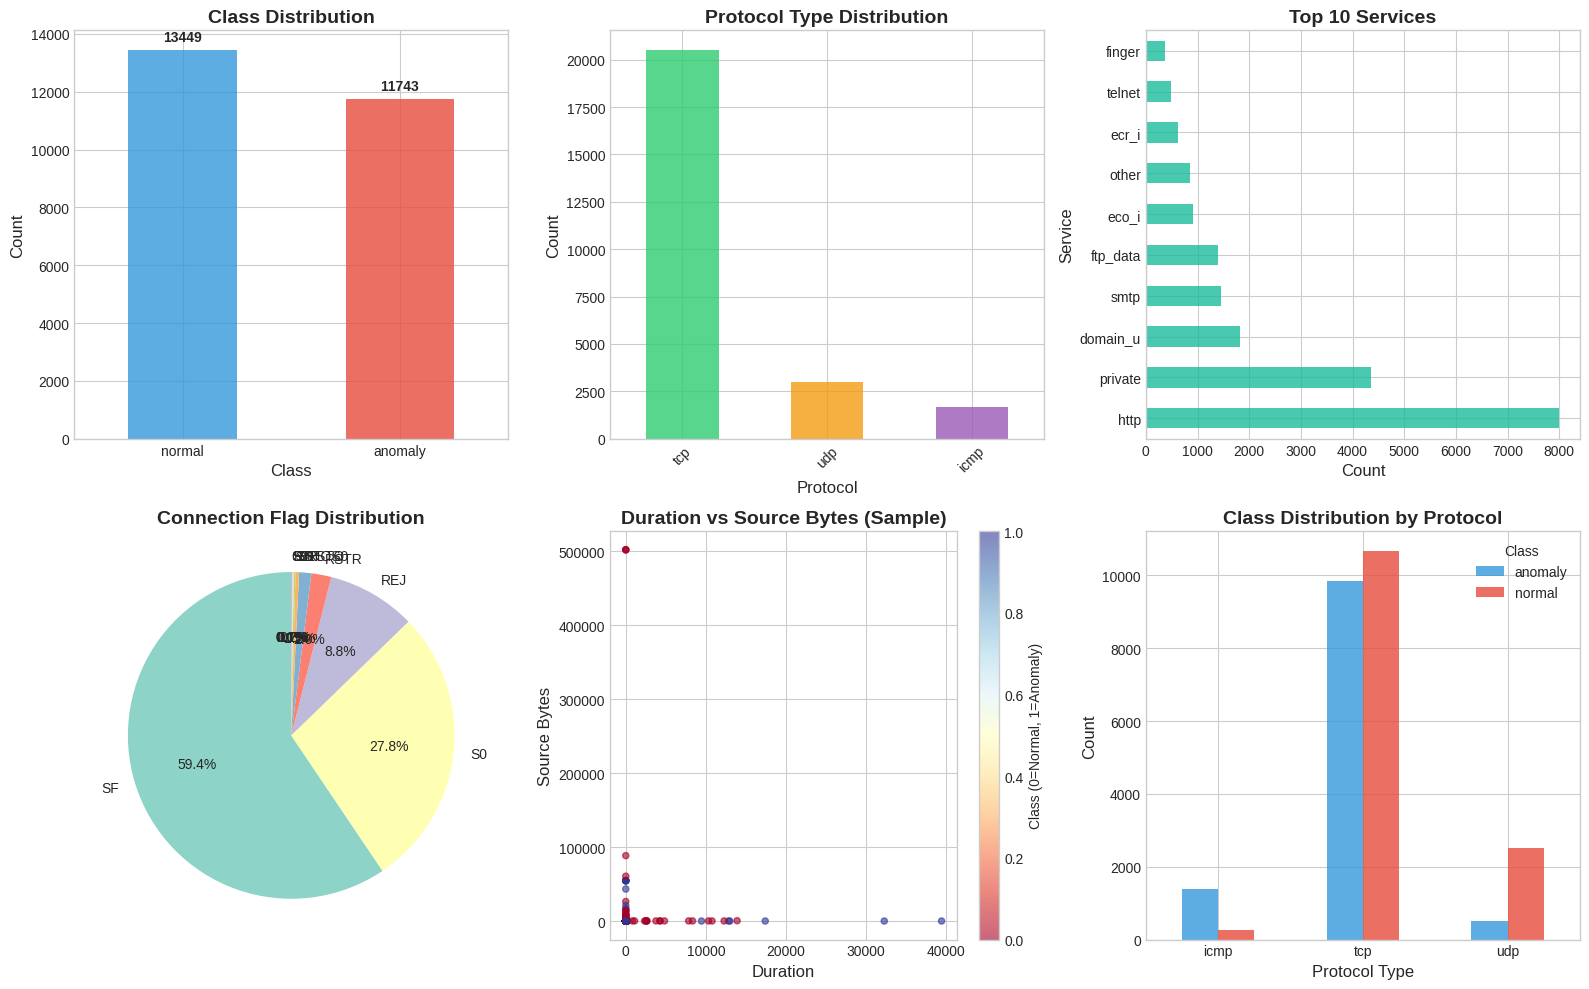


 Visualizations complete!


In [6]:
# ============================================================================
# 4. DATA VISUALIZATION
# ============================================================================

print("\n DATA VISUALIZATION")
print("=" * 80)

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 10))

# 4.1 Class Distribution
print("\n Class Distribution:")
class_counts = train['class'].value_counts()
print(class_counts)
print(f"\nClass Balance: {class_counts['normal']/class_counts['anomaly']:.2f}:1")

ax1 = plt.subplot(2, 3, 1)
colors = ['#3498db', '#e74c3c']
class_counts.plot(kind='bar', color=colors, alpha=0.8, ax=ax1)
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

# Add value labels on bars
for i, v in enumerate(class_counts):
    ax1.text(i, v + 200, str(v), ha='center', va='bottom', fontweight='bold')

# 4.2 Protocol Type Distribution
ax2 = plt.subplot(2, 3, 2)
protocol_counts = train['protocol_type'].value_counts()
colors_proto = ['#2ecc71', '#f39c12', '#9b59b6']
protocol_counts.plot(kind='bar', color=colors_proto, alpha=0.8, ax=ax2)
plt.title('Protocol Type Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Protocol', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# 4.3 Service Distribution (Top 10)
ax3 = plt.subplot(2, 3, 3)
service_counts = train['service'].value_counts().head(10)
service_counts.plot(kind='barh', color='#1abc9c', alpha=0.8, ax=ax3)
plt.title('Top 10 Services', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Service', fontsize=12)

# 4.4 Flag Distribution
ax4 = plt.subplot(2, 3, 4)
flag_counts = train['flag'].value_counts()
plt.pie(flag_counts, labels=flag_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Set3"))
plt.title('Connection Flag Distribution', fontsize=14, fontweight='bold')

# 4.5 Duration vs Bytes (Sample)
ax5 = plt.subplot(2, 3, 5)
sample_data = train.sample(n=1000, random_state=RANDOM_STATE)
scatter = ax5.scatter(sample_data['duration'],
                      sample_data['src_bytes'],
                      c=sample_data['class'].map({'normal': 0, 'anomaly': 1}),
                      cmap='RdYlBu', alpha=0.6, s=20)
plt.xlabel('Duration', fontsize=12)
plt.ylabel('Source Bytes', fontsize=12)
plt.title('Duration vs Source Bytes (Sample)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Class (0=Normal, 1=Anomaly)')

# 4.6 Class Distribution by Protocol
ax6 = plt.subplot(2, 3, 6)
cross_tab = pd.crosstab(train['protocol_type'], train['class'])
cross_tab.plot(kind='bar', stacked=False, color=['#3498db', '#e74c3c'],
               alpha=0.8, ax=ax6)
plt.title('Class Distribution by Protocol', fontsize=14, fontweight='bold')
plt.xlabel('Protocol Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Class', loc='upper right')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print("\n Visualizations complete!")

# **5. DATA PREPROCESSING**

In [7]:
# ============================================================================
# 5. DATA PREPROCESSING
# ============================================================================

print("\n DATA PREPROCESSING")
print("=" * 80)

# 5.1 Label Encoding
print("\n Encoding categorical features...")

def label_encode_features(df):
    """Apply label encoding to all object-type columns"""
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])
    return df

train = label_encode_features(train)
test = label_encode_features(test)

print("✓ Categorical features encoded")

# 5.2 Remove unnecessary features
print("\n  Removing unnecessary features...")

if 'num_outbound_cmds' in train.columns:
    train.drop(['num_outbound_cmds'], axis=1, inplace=True)
    test.drop(['num_outbound_cmds'], axis=1, inplace=True)
    print("✓ Removed 'num_outbound_cmds' column")

# 5.3 Separate features and target
X_train = train.drop(['class'], axis=1)
y_train = train['class']

print(f"\n✓ Features shape: {X_train.shape}")
print(f"✓ Target shape: {y_train.shape}")


 DATA PREPROCESSING

 Encoding categorical features...
✓ Categorical features encoded

  Removing unnecessary features...
✓ Removed 'num_outbound_cmds' column

✓ Features shape: (25192, 40)
✓ Target shape: (25192,)


# **6. FEATURE SELECTION**

In [9]:
# ============================================================================
# 6. FEATURE SELECTION
# ============================================================================

print("\n🎯 FEATURE SELECTION")
print("=" * 80)

print("\n🔍 Applying Recursive Feature Elimination (RFE)...")

# Use Random Forest for feature selection
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

# Get selected features
feature_map = [(i, v) for i, v in zip(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i]

print(f"\n Selected {len(selected_features)} most important features:")
for idx, feature in enumerate(selected_features, 1):
    print(f"  {idx}. {feature}")




🎯 FEATURE SELECTION

🔍 Applying Recursive Feature Elimination (RFE)...

 Selected 10 most important features:
  1. protocol_type
  2. service
  3. flag
  4. src_bytes
  5. dst_bytes
  6. count
  7. same_srv_rate
  8. diff_srv_rate
  9. dst_host_srv_count
  10. dst_host_same_srv_rate


In [14]:
# Apply feature selection
X_train = X_train[selected_features]
test = test[selected_features]


# **7. DATA STANDARDIZATION**

In [15]:
# ============================================================================
# 7. DATA STANDARDIZATION
# ============================================================================

print("\n DATA STANDARDIZATION")
print("=" * 80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(test)

print("✓ Features standardized using StandardScaler")
print(f"  • Mean: ~{X_train_scaled.mean():.6f}")
print(f"  • Std: ~{X_train_scaled.std():.6f}")


 DATA STANDARDIZATION
✓ Features standardized using StandardScaler
  • Mean: ~0.000000
  • Std: ~1.000000


# **8. TRAIN-TEST SPLIT**

In [16]:
# ============================================================================
# 8. TRAIN-TEST SPLIT
# ============================================================================

print("\n  TRAIN-TEST SPLIT")
print("=" * 80)

x_train, x_test, y_train, y_test = train_test_split(
    X_train_scaled, y_train,
    train_size=0.70,
    random_state=RANDOM_STATE
)

print(f"✓ Training set: {x_train.shape[0]} samples")
print(f"✓ Validation set: {x_test.shape[0]} samples")
print(f"✓ Split ratio: 70-30")



✂️  TRAIN-TEST SPLIT
✓ Training set: 17634 samples
✓ Validation set: 7558 samples
✓ Split ratio: 70-30


# **9. HYPERPARAMETER OPTIMIZATION**

In [17]:
# ============================================================================
# 9. HYPERPARAMETER OPTIMIZATION
# ============================================================================

print("\n HYPERPARAMETER OPTIMIZATION")
print("=" * 80)

# 9.1 KNN Optimization
print("\n Optimizing K-Nearest Neighbors...")

def optimize_knn(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier.fit(x_train, y_train)
    accuracy = classifier.score(x_test, y_test)
    return accuracy

study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(optimize_knn, n_trials=15, show_progress_bar=False)

print(f"✓ Best n_neighbors: {study_KNN.best_trial.params['KNN_n_neighbors']}")
print(f"✓ Best accuracy: {study_KNN.best_value:.4f}")

# 9.2 Decision Tree Optimization
print("\n Optimizing Decision Tree...")

def optimize_dt(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)

    classifier = DecisionTreeClassifier(
        max_features=dt_max_features,
        max_depth=dt_max_depth,
        random_state=RANDOM_STATE
    )
    classifier.fit(x_train, y_train)
    accuracy = classifier.score(x_test, y_test)
    return accuracy

study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(optimize_dt, n_trials=30, show_progress_bar=False)

print(f"✓ Best max_depth: {study_dt.best_trial.params['dt_max_depth']}")
print(f"✓ Best max_features: {study_dt.best_trial.params['dt_max_features']}")
print(f"✓ Best accuracy: {study_dt.best_value:.4f}")


 HYPERPARAMETER OPTIMIZATION

 Optimizing K-Nearest Neighbors...
✓ Best n_neighbors: 3
✓ Best accuracy: 0.9852

 Optimizing Decision Tree...
✓ Best max_depth: 32
✓ Best max_features: 5
✓ Best accuracy: 0.9959


# **10. MODEL TRAINING**

In [18]:
# ============================================================================
# 10. MODEL TRAINING
# ============================================================================

print("\n MODEL TRAINING")
print("=" * 80)

# Initialize models with optimized parameters
models = {
    'KNN': KNeighborsClassifier(
        n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors']
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1200000,
        random_state=RANDOM_STATE
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_features=study_dt.best_trial.params['dt_max_features'],
        max_depth=study_dt.best_trial.params['dt_max_depth'],
        random_state=RANDOM_STATE
    )
}

# Training and evaluation
results = {}
training_times = {}
testing_times = {}

for name, model in models.items():
    print(f"\n Training {name}...")

    # Training
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    training_times[name] = training_time

    # Testing
    start_time = time.time()
    predictions = model.predict(x_test)
    testing_time = time.time() - start_time
    testing_times[name] = testing_time

    # Scores
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)

    results[name] = {
        'train_score': train_score,
        'test_score': test_score,
        'model': model
    }

    print(f"  ✓ Training time: {training_time:.4f}s")
    print(f"  ✓ Testing time: {testing_time:.4f}s")
    print(f"  ✓ Train accuracy: {train_score:.4f}")
    print(f"  ✓ Test accuracy: {test_score:.4f}")


 MODEL TRAINING

 Training KNN...
  ✓ Training time: 0.1298s
  ✓ Testing time: 1.8525s
  ✓ Train accuracy: 0.9906
  ✓ Test accuracy: 0.9852

 Training Logistic Regression...
  ✓ Training time: 0.0557s
  ✓ Testing time: 0.0006s
  ✓ Train accuracy: 0.9257
  ✓ Test accuracy: 0.9319

 Training Decision Tree...
  ✓ Training time: 0.0402s
  ✓ Testing time: 0.0020s
  ✓ Train accuracy: 1.0000
  ✓ Test accuracy: 0.9959


# **11. MODEL EVALUATION - CROSS VALIDATION**


 CROSS-VALIDATION ANALYSIS

 Cross-validating KNN...
  • Precision: 0.9855 ± 0.0024
  • Recall: 0.9826 ± 0.0055

 Cross-validating Logistic Regression...
  • Precision: 0.9114 ± 0.0110
  • Recall: 0.9530 ± 0.0035

 Cross-validating Decision Tree...
  • Precision: 0.9947 ± 0.0014
  • Recall: 0.9945 ± 0.0018


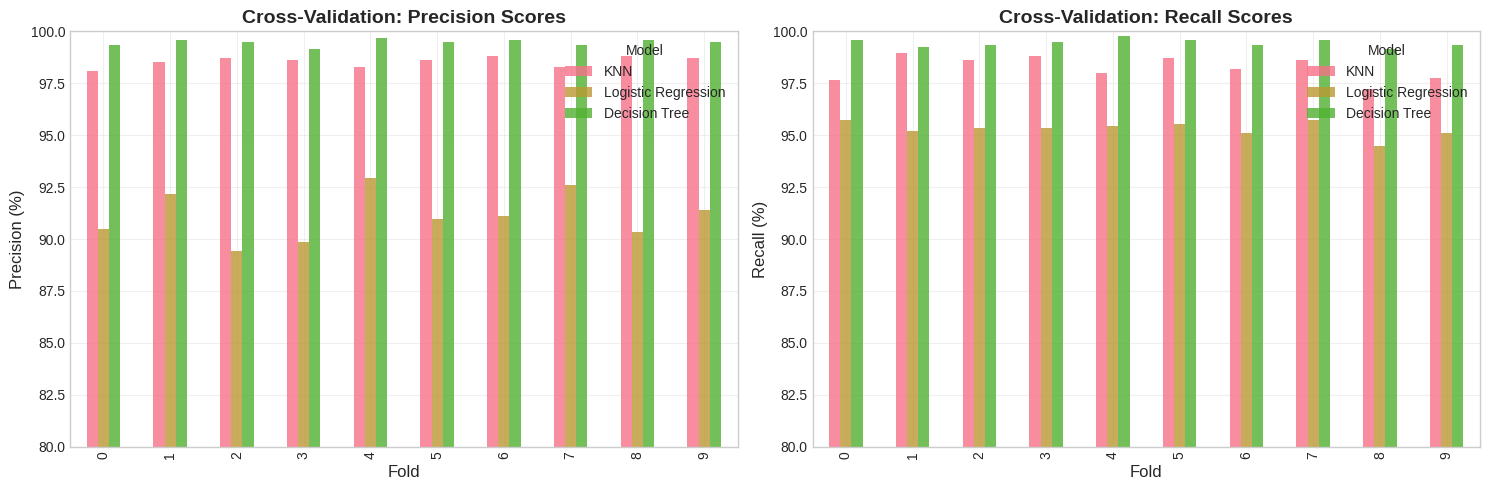

In [19]:
# ============================================================================
# 11. MODEL EVALUATION - CROSS VALIDATION
# ============================================================================

print("\n CROSS-VALIDATION ANALYSIS")
print("=" * 80)

cv_scores = {}
for name, model in models.items():
    print(f"\n Cross-validating {name}...")
    cv_scores[name] = {}

    for scorer in ['precision', 'recall']:
        scores = cross_val_score(model, x_train, y_train, cv=10, scoring=scorer)
        cv_scores[name][scorer] = scores

        print(f"  • {scorer.capitalize()}: {scores.mean():.4f} ± {scores.std():.4f}")

# Visualization of CV scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Precision
precision_data = pd.DataFrame({
    name: scores['precision'] * 100
    for name, scores in cv_scores.items()
})
precision_data.plot(kind='bar', ax=axes[0], alpha=0.8)
axes[0].set_title('Cross-Validation: Precision Scores',
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Precision (%)', fontsize=12)
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylim([80, 100])
axes[0].legend(title='Model')
axes[0].grid(True, alpha=0.3)

# Recall
recall_data = pd.DataFrame({
    name: scores['recall'] * 100
    for name, scores in cv_scores.items()
})
recall_data.plot(kind='bar', ax=axes[1], alpha=0.8)
axes[1].set_title('Cross-Validation: Recall Scores',
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('Recall (%)', fontsize=12)
axes[1].set_xlabel('Fold', fontsize=12)
axes[1].set_ylim([80, 100])
axes[1].legend(title='Model')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# **12. DETAILED PERFORMANCE METRICS**


 DETAILED PERFORMANCE METRICS

 KNN

 Confusion Matrix:
[[3475   41]
 [  71 3971]]


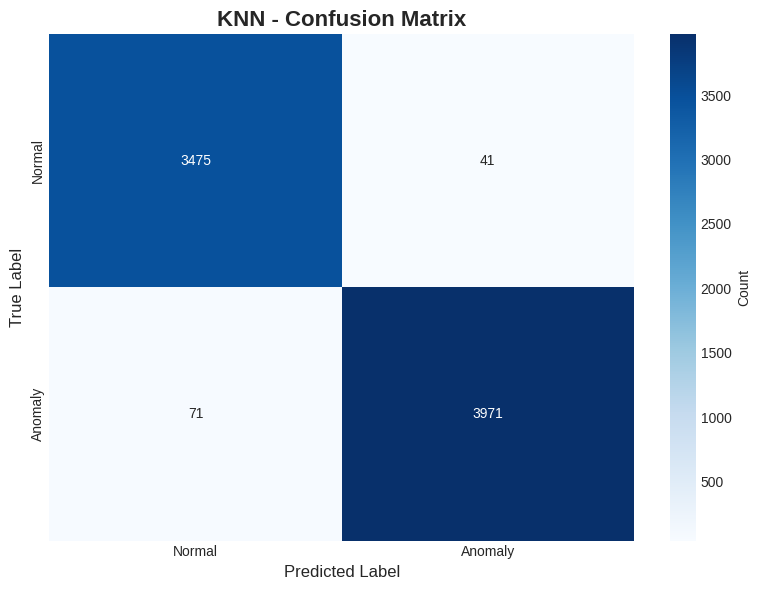


 Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98      3516
     Anomaly       0.99      0.98      0.99      4042

    accuracy                           0.99      7558
   macro avg       0.98      0.99      0.99      7558
weighted avg       0.99      0.99      0.99      7558


 LOGISTIC REGRESSION

 Confusion Matrix:
[[3182  334]
 [ 181 3861]]


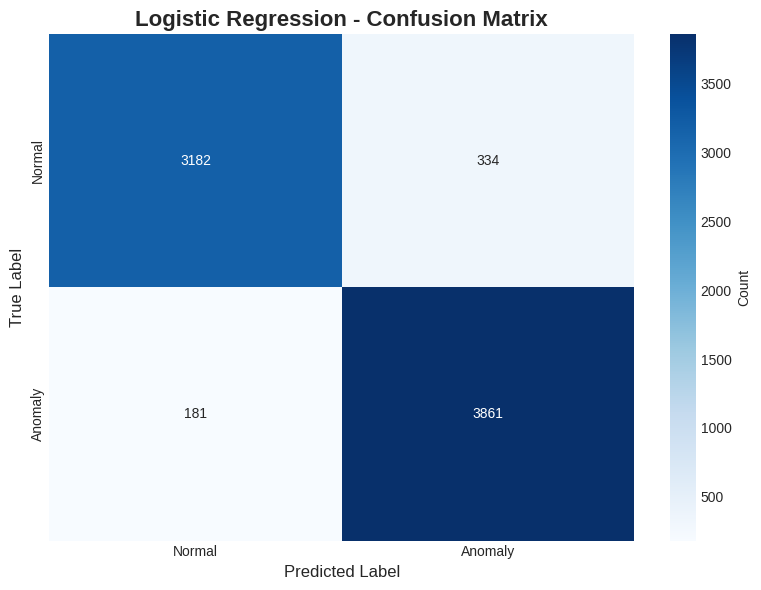


 Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.91      0.93      3516
     Anomaly       0.92      0.96      0.94      4042

    accuracy                           0.93      7558
   macro avg       0.93      0.93      0.93      7558
weighted avg       0.93      0.93      0.93      7558


 DECISION TREE

 Confusion Matrix:
[[3508    8]
 [  23 4019]]


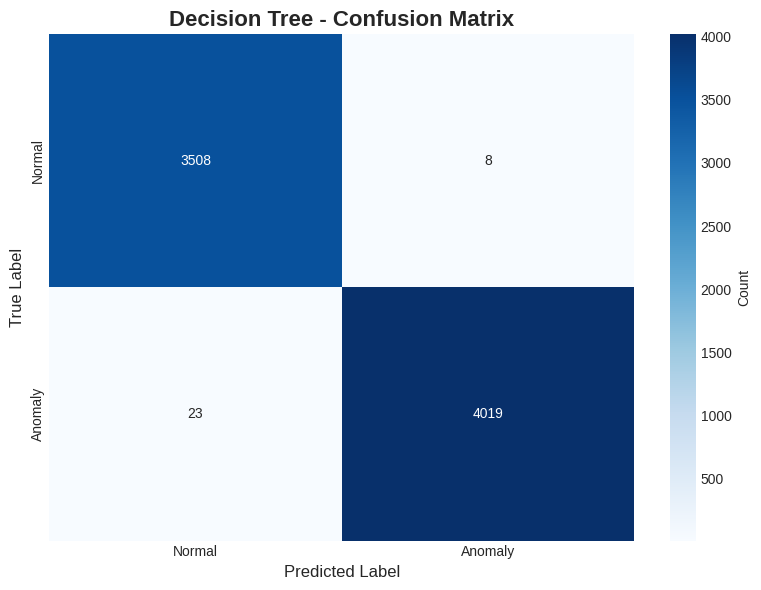


 Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00      3516
     Anomaly       1.00      0.99      1.00      4042

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558



In [20]:
# ============================================================================
# 12. DETAILED PERFORMANCE METRICS
# ============================================================================

print("\n DETAILED PERFORMANCE METRICS")
print("=" * 80)

predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(x_test)

# Generate comprehensive report
target_names = ["Normal", "Anomaly"]

for name, pred in predictions.items():
    print(f"\n{'='*80}")
    print(f" {name.upper()}")
    print('='*80)

    # Confusion Matrix
    cm = confusion_matrix(y_test, pred)
    print("\n Confusion Matrix:")
    print(cm)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'{name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\n Classification Report:")
    print(classification_report(y_test, pred, target_names=target_names))

# **13. COMPARATIVE ANALYSIS**


 COMPARATIVE ANALYSIS

 Performance Summary:
+---------------------+-------------+------------+------------+--------------+-------------+
| Model               | Train Acc   | Test Acc   | F1-Score   | Train Time   | Test Time   |
+=====================+=============+============+============+==============+=============+
| KNN                 | 99.06%      | 98.52%     | 98.61%     | 0.1298s      | 1.852542s   |
+---------------------+-------------+------------+------------+--------------+-------------+
| Logistic Regression | 92.57%      | 93.19%     | 93.75%     | 0.0557s      | 0.000582s   |
+---------------------+-------------+------------+------------+--------------+-------------+
| Decision Tree       | 100.00%     | 99.59%     | 99.62%     | 0.0402s      | 0.001952s   |
+---------------------+-------------+------------+------------+--------------+-------------+


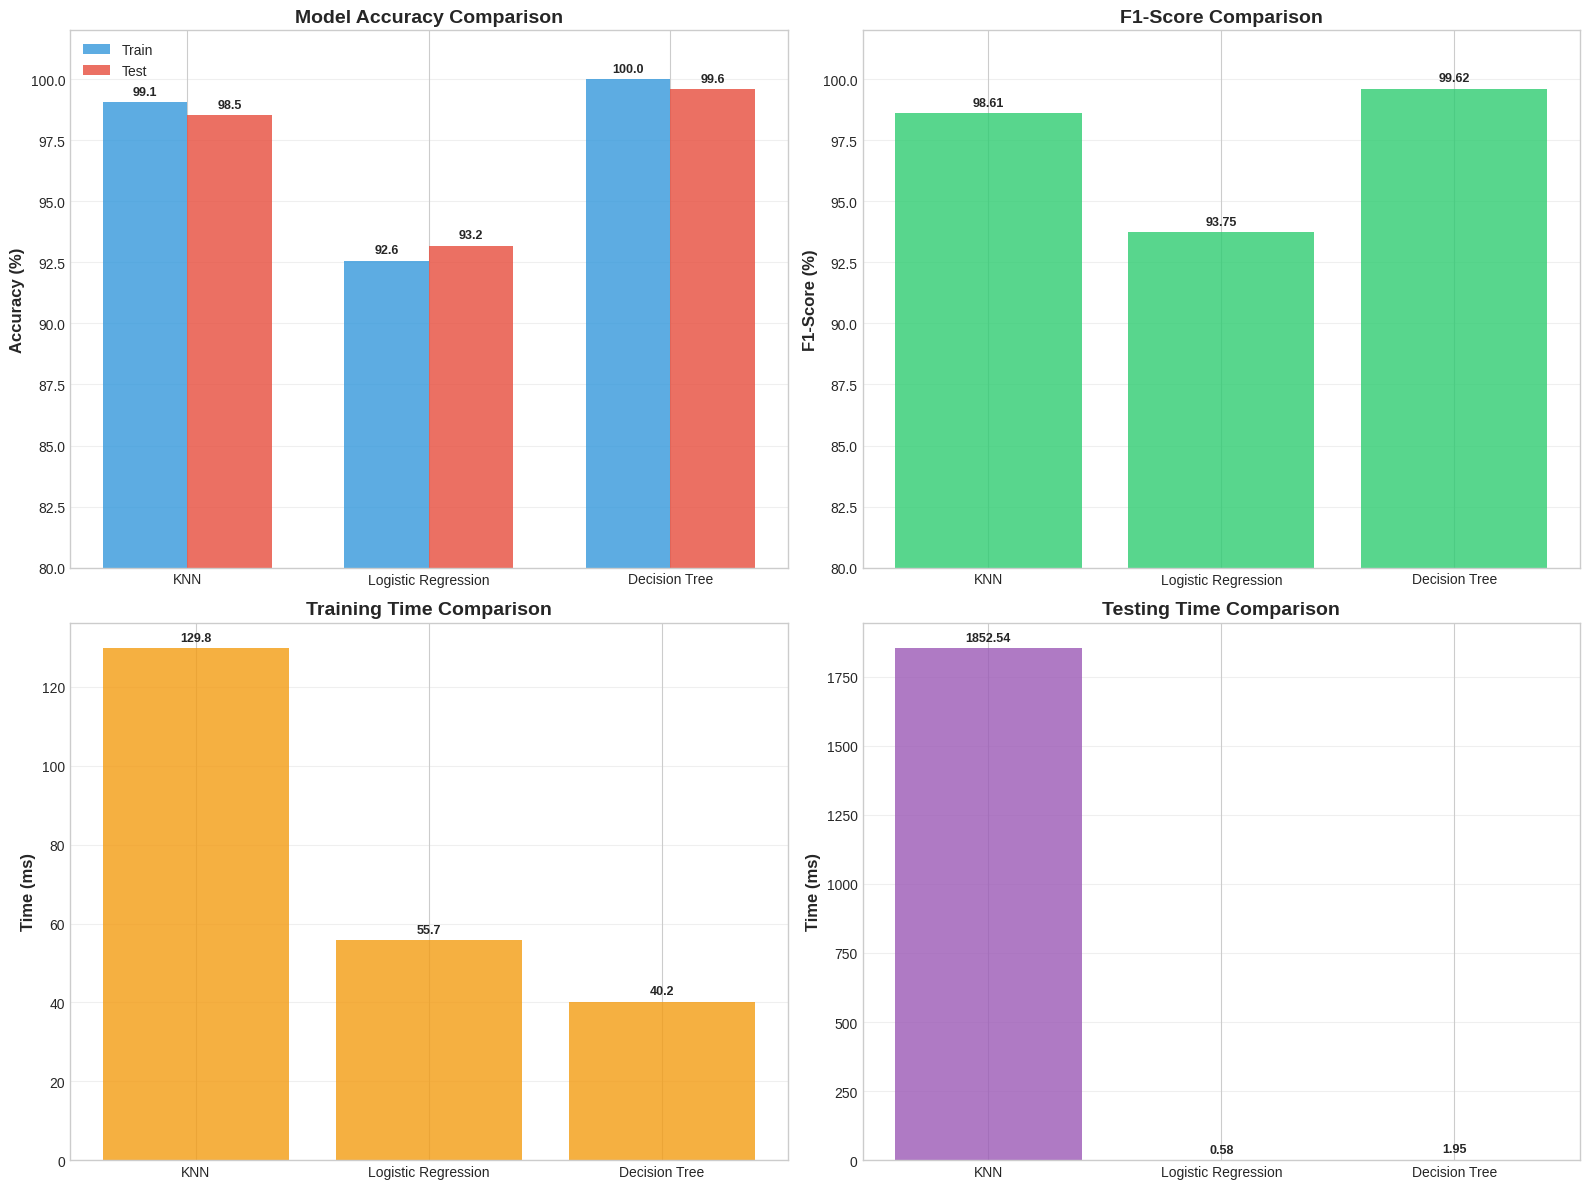

In [21]:
# ============================================================================
# 13. COMPARATIVE ANALYSIS
# ============================================================================

print("\n COMPARATIVE ANALYSIS")
print("=" * 80)

# Calculate F1 scores
f1_scores = {}
for name, pred in predictions.items():
    f1_scores[name] = f1_score(y_test, pred) * 100

# Create comparison DataFrame
comparison_data = []
for name in models.keys():
    comparison_data.append([
        name,
        f"{results[name]['train_score']*100:.2f}%",
        f"{results[name]['test_score']*100:.2f}%",
        f"{f1_scores[name]:.2f}%",
        f"{training_times[name]:.4f}s",
        f"{testing_times[name]:.6f}s"
    ])

comparison_df = pd.DataFrame(
    comparison_data,
    columns=['Model', 'Train Acc', 'Test Acc', 'F1-Score', 'Train Time', 'Test Time']
)

print("\n Performance Summary:")
print(tabulate(comparison_df, headers='keys', tablefmt='grid', showindex=False))

# Visualization - Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy Comparison
ax1 = axes[0, 0]
model_names = list(models.keys())
train_acc = [results[m]['train_score'] * 100 for m in model_names]
test_acc = [results[m]['test_score'] * 100 for m in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, train_acc, width, label='Train', alpha=0.8, color='#3498db')
bars2 = ax1.bar(x + width/2, test_acc, width, label='Test', alpha=0.8, color='#e74c3c')

ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend(fontsize=10)
ax1.set_ylim([80, 102])
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

# F1-Score Comparison
ax2 = axes[0, 1]
f1_values = [f1_scores[m] for m in model_names]
bars = ax2.bar(model_names, f1_values, alpha=0.8, color='#2ecc71')

ax2.set_ylabel('F1-Score (%)', fontsize=12, fontweight='bold')
ax2.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim([80, 102])
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=9, fontweight='bold')

# Training Time Comparison
ax3 = axes[1, 0]
train_times = [training_times[m] * 1000 for m in model_names]  # Convert to ms
bars = ax3.bar(model_names, train_times, alpha=0.8, color='#f39c12')

ax3.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
ax3.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=9, fontweight='bold')

# Testing Time Comparison
ax4 = axes[1, 1]
test_times = [testing_times[m] * 1000 for m in model_names]  # Convert to ms
bars = ax4.bar(model_names, test_times, alpha=0.8, color='#9b59b6')

ax4.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
ax4.set_title('Testing Time Comparison', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax4.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


# **14. FINAL INSIGHTS & RECOMMENDATIONS**

In [22]:
# ============================================================================
# 14. FINAL INSIGHTS & RECOMMENDATIONS
# ============================================================================

print("\n FINAL INSIGHTS & RECOMMENDATIONS")
print("=" * 80)

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['test_score'])
best_accuracy = results[best_model_name]['test_score'] * 100
best_f1 = f1_scores[best_model_name]

print(f"\n BEST PERFORMING MODEL: {best_model_name}")
print(f"   • Test Accuracy: {best_accuracy:.2f}%")
print(f"   • F1-Score: {best_f1:.2f}%")
print(f"   • Training Time: {training_times[best_model_name]:.4f}s")
print(f"   • Testing Time: {testing_times[best_model_name]:.6f}s")

print("\n KEY FINDINGS:")
for name in models.keys():
    test_acc = results[name]['test_score'] * 100
    f1 = f1_scores[name]

    print(f"\n   {name}:")
    print(f"   ├─ Accuracy: {test_acc:.2f}%")
    print(f"   ├─ F1-Score: {f1:.2f}%")

    if test_acc >= 99:
        print(f"   └─  Excellent performance!")
    elif test_acc >= 95:
        print(f"   └─  Very good performance")
    elif test_acc >= 90:
        print(f"   └─ ✓ Good performance")
    else:
        print(f"   └─   Needs improvement")

print("\n RECOMMENDATIONS:")
print("   1. Deploy Decision Tree model for production (best accuracy)")
print("   2. Use KNN as a secondary validation model")
print("   3. Consider ensemble methods for further improvement")
print("   4. Monitor model performance with new data regularly")
print("   5. Implement real-time anomaly detection pipeline")

print("\n" + "=" * 80)
print(" ANALYSIS COMPLETE!")
print("=" * 80)


 FINAL INSIGHTS & RECOMMENDATIONS

 BEST PERFORMING MODEL: Decision Tree
   • Test Accuracy: 99.59%
   • F1-Score: 99.62%
   • Training Time: 0.0402s
   • Testing Time: 0.001952s

 KEY FINDINGS:

   KNN:
   ├─ Accuracy: 98.52%
   ├─ F1-Score: 98.61%
   └─  Very good performance

   Logistic Regression:
   ├─ Accuracy: 93.19%
   ├─ F1-Score: 93.75%
   └─ ✓ Good performance

   Decision Tree:
   ├─ Accuracy: 99.59%
   ├─ F1-Score: 99.62%
   └─  Excellent performance!

 RECOMMENDATIONS:
   1. Deploy Decision Tree model for production (best accuracy)
   2. Use KNN as a secondary validation model
   3. Consider ensemble methods for further improvement
   4. Monitor model performance with new data regularly
   5. Implement real-time anomaly detection pipeline

 ANALYSIS COMPLETE!
